# 0 Import Statements

In [85]:
#!pip install opencv-python
#!pip install scikit-learn
#!pip install imblearn
#!pip install tensorflow
#!pip install seaborn

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input, AveragePooling2D, concatenate
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(1000)

# 1 Preprocessing

## 1.1 Read-in data

In [5]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [6]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

## 1.2 SHUFFLE

In [7]:
# shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df_shuffled.head(5))

X = df_shuffled["image"]
y = df_shuffled["label"]

                          image  label
0  ESP_027475_2310_RED-0112.jpg      0
1  ESP_034557_1510_RED-0201.jpg      0
2  PSP_002455_1320_RED-0111.jpg      2
3  PSP_010587_1620_RED-0342.jpg      0
4  ESP_033955_2065_RED-0059.jpg      0


## 1.3 Train-Test-Split

In [22]:
Xp_train_before, Xp_test, yp_train_before, yp_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(Xp_train_before.shape, yp_train_before.shape, "Train")
print(Xp_test.shape, yp_test.shape, "Test")

(6489,) (6489,) Train
(4326,) (4326,) Test


In [23]:
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]


## 1.4 Delete 4.5k images in the train set

In [28]:
# delte 6k images from the train set and corresponding labels
index = Xp_train_before[yp_train_before == 0].sample(n=4500, random_state=42).index
Xp_train = Xp_train_before.drop(index)
yp_train = yp_train_before.drop(index)

print(Xp_train.shape, yp_train.shape)
print("Distribution of labels in the train set")
print(np.unique(yp_train, return_counts=True))
print(np.around(np.unique(yp_train, return_counts=True)[1]/yp_train.shape[0], decimals=4))

(1989,) (1989,)
Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]


## 1.5 Read-in images and normalize

In [29]:
# function that normalizes an input image
def normalize_image(image):
    image = image/255.0
    return image

# function that loads the images from the path in an array and returns the array as well as the correspoding label
def load_images(X, y, folder):
    images = []
    labels = []
    for index in X.index:
        image = cv2.imread(folder+"/"+X[index], cv2.IMREAD_GRAYSCALE)
        image = normalize_image(image)
        if images is not None:
            images.append(image)
            labels.append(y[index])
    return np.array(images), np.array(labels)

In [30]:
# load the images from the train, test, and validation set
X_train, y_train = load_images(Xp_train, yp_train, "map-proj-v3_2")
X_test, y_test = load_images(Xp_test, yp_test, "map-proj-v3_2")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1989, 227, 227) (1989,)
(4326, 227, 227) (4326,)


In [31]:
print("Distribution of labels in the train set before deleting 5.4k images")
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))
print("\nDistribution of labels in the train set")
print(np.unique(y_train, return_counts=True))
print(np.around(np.unique(y_train, return_counts=True)[1]/y_train.shape[0], decimals=4))
print("\nDistribution of labels in the test set")
print(np.unique(y_test, return_counts=True))
print(np.around(np.unique(y_test, return_counts=True)[1]/y_test.shape[0], decimals=4))

Distribution of labels in the train set before deleting 5.4k images
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]

Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]

Distribution of labels in the test set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([3562,  315,   64,   86,   98,   27,  117,   57]))
[0.8234 0.0728 0.0148 0.0199 0.0227 0.0062 0.027  0.0132]


## 1.6 Imbalance handling

### 1.6.0 Flatten images

In [72]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(1989, 227, 227)
(1989, 51529)


### 1.6.1 ADASYN

In [73]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

### 1.6.2 Oversampling

In [35]:
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [36]:
#l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
#print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
#all_l = pd.DataFrame(X_resampled)
#print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 261
Number of duplicates for all labels after oversampling: 3931


In [37]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

(5891, 51529)
[0 1 2 3 4 5 6 7] [740 479 102 181 152  47 181 107]
[0 1 2 3 4 5 6 7] [740 701 730 729 748 736 767 740]
[0 1 2 3 4 5 6 7] [740 740 740 740 740 740 740 740]


In [38]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training instances generated by ADASYN: 
(5891, 227, 227), correspoding y: (5891,)
Shape of training instances generated by RandomOverSampler: 
(5920, 227, 227), correspoding y: (5920,)


## 1.7 Augmentation
Rotate 90, 180, 270, Flip Horizontally, Flip Vertically, Zoom (1.2)

In [74]:
def zoom_at(img, zoom):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def augment_images(images, labels):
    """
    Augments a numpy array of images by rotating them by 90, 180, and 270 degrees, flipping them horizontally and
    vertically, and zooming in on them.
    
    Args:
    - images (numpy.ndarray): A numpy array of shape (N, H, W, C), where N is the number of images, H and W are the
                              height and width of the images, and C is the number of color channels.
                              
    Returns:
    - augmented_images (numpy.ndarray): A numpy array of shape (7N, H, W, C), where the first N images are the
                                         original images and the remaining 6N images are the augmented images.
    """
    # Initialize an empty numpy array to store the augmented images
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    

    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        #print(f"Image, {i} done")

    return augmented_images, augmented_labels

In [76]:
X_t_A_A, y_t_A_A = augment_images(X_t_A, y_t_A)
X_t_O_A, y_t_O_A = augment_images(X_t_O, y_t_O)
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

Shape of original training data for ADASYN: (5891, 227, 227) with corresponding y: (5891,)
Shape of augmented training data for ADASYN: (700, 227, 227) with corresponding y: (700,)
Shape of original training data for RandomOverSampler: (5920, 227, 227) with corresponding y: (5920,)
Shape of augmented training data for RandomOverSampler: (700, 227, 227) with corresponding y: (700,)


In [42]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# function that generates 10 random integers from numpy array that are divisible by 7
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# create function that takes 10 random images from the augmented training data and plots them
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

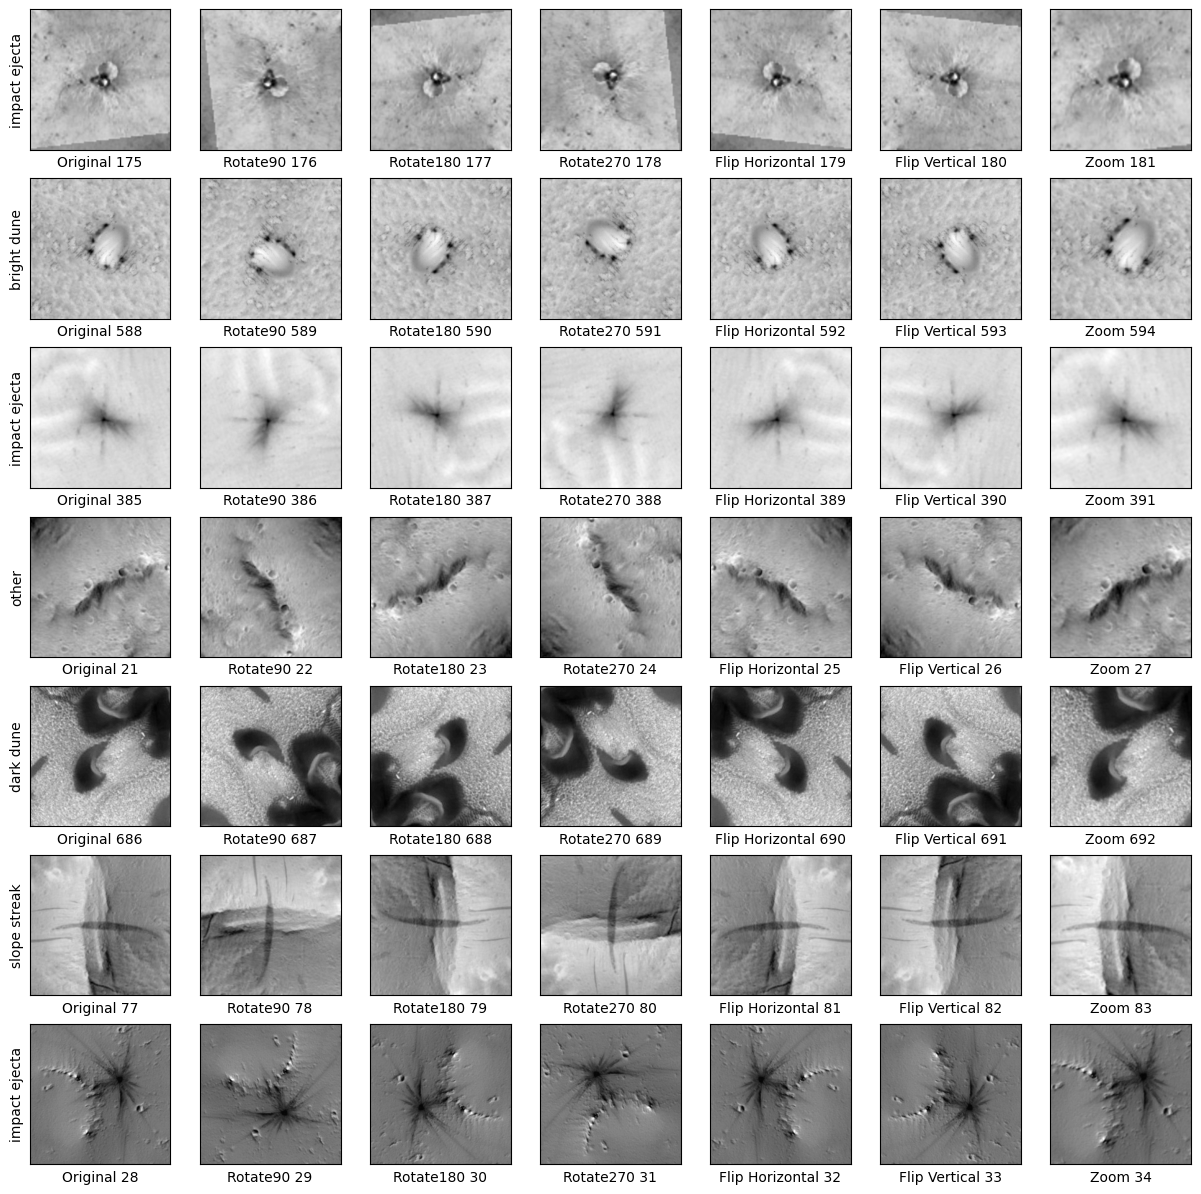

In [43]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

# 2 Apply Models

In [45]:
def shuffle_data(x, y):
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]

In [46]:
def model_evaluation(model, history, X_test, y_test, class_names):
    sns.lineplot(data=history.history['accuracy'], label='accuracy')
    sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    print("Accuracy on the training set:", test_acc)
    y_pred_prob = model.predict(X_test)
    y_pred_class = y_pred_prob.argmax(axis=-1)

    print(classification_report(y_pred_class, y_test, target_names=class_names))
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_pred_class, y_test), xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.show()

## 2.1 AlexNet

In [47]:
def create_alex(learning_rate):
    alex = Sequential()
    
    alex.add(Conv2D(filters=96, input_shape=(227, 227, 1), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Flatten())
    alex.add(Dense(4096, input_shape=(227*227*1,), activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(4096, activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(8))
    alex.add(Activation('softmax'))

    # print the model summary
    alex.summary()

    # Define optimizer and loss function
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=0.0005, momentum=0.9, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    # Compile the model
    alex.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    return alex

## 2.2 GoogLeNet

In [66]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

def GoogLeNet():
    input_layer = Input(shape=(227, 227, 1))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1000, activation='sigmoid')(x)
    output_layer = Dense(8, activation='softmax')(x)

    # Define the model
    model_googlenet = keras.Model(input_layer, output_layer)

    # Return the model
    return model_googlenet

def create_google(learning_rate):
    google = GoogLeNet()
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    google.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])
    
    return google

## 2.3 Select Model and dataset to run

In [78]:
# Define model function
model_f = create_alex
#model_f = create_google

# Define dataset
X_model, y_model = shuffle_data(X_t_A_A, y_t_A_A)
#X_model, y_model = shuffle_data(X_t_O_A, y_t_O_A)

In [80]:
# Custom classifier that allows for a learning rate
def classifier(model_function, learning_rate=0.01):
    model = KerasClassifier(model=model_function, learning_rate=learning_rate)
    return model

# Grid search parameters
param_grid = {"learning_rate": [0.01, 0.005],
                "batch_size": [32, 128],
                "epochs": [10, 20]}

param_grid = {"learning_rate": [0.01],
                "batch_size": [32],
                "epochs": [1, 2]}

start_time = time.time()
grid = GridSearchCV(estimator=classifier(model_function=model_f), param_grid=param_grid, n_jobs=-1, cv=3, return_train_score=True)
grid_result = grid.fit(X_model, y_model)
end_time = time.time()
execution_time = (end_time - start_time) / 60
print("Execution time:", execution_time, "minutes")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

## 2.4 Results

In [81]:
# summarize results
print(f"Best: {round(grid_result.best_score_, 2)} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{round(mean, 4)} ({round(stdev, 4)}) with: {param}")

Best: 0.16 using {'batch_size': 32, 'epochs': 2, 'learning_rate': 0.01}
0.1572 (0.0056) with: {'batch_size': 32, 'epochs': 1, 'learning_rate': 0.01}
0.16 (0.0022) with: {'batch_size': 32, 'epochs': 2, 'learning_rate': 0.01}


batch_size 32
epochs 2
learning_rate 0.01


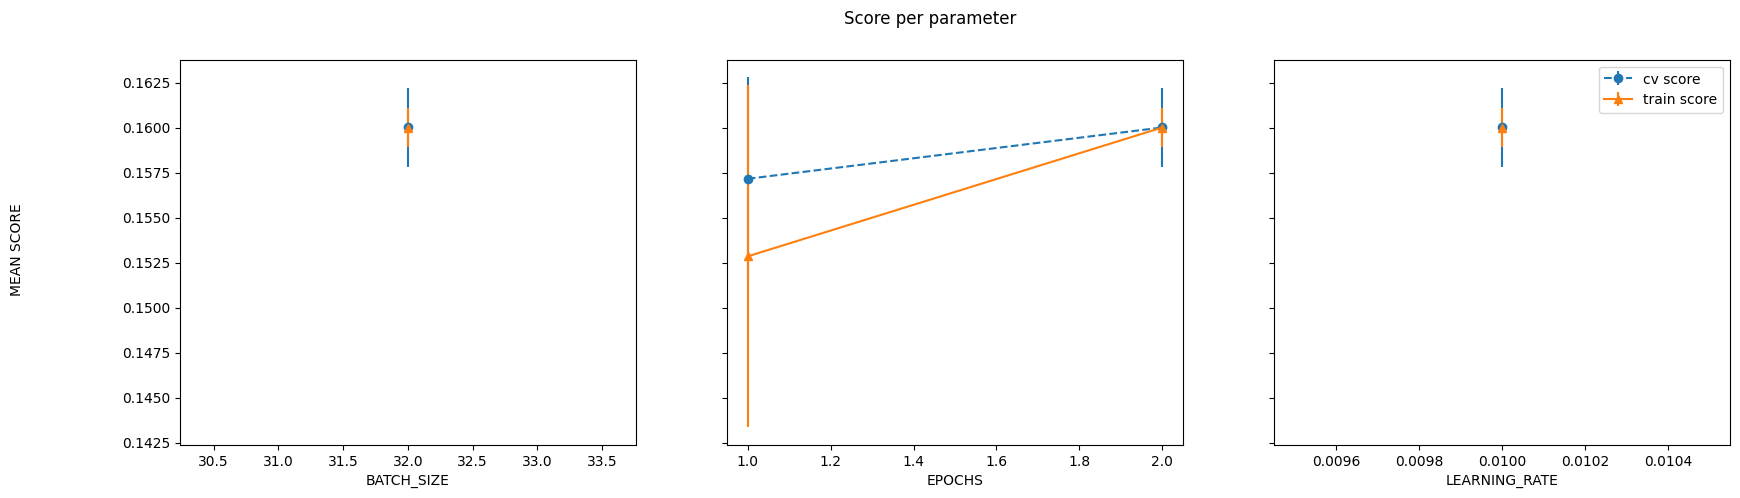

In [84]:
results = grid.cv_results_
params=grid.param_grid

means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

# Getting indexes of values per hyperparameter
masks=[]
masks_names= list(grid.best_params_.keys())
for p_k, p_v in grid.best_params_.items():
    print(p_k, p_v)
    masks.append(list(results['param_'+p_k].data==p_v))

# Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    #pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='cv score')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train score' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

136/136 [==============================] - 39s 279ms/step
(4326, 227, 227)
(4326,)
Accuracy: 0.019879796578825704
               precision    recall  f1-score   support

        other       0.00      0.00      0.00      3562
       crater       0.00      0.00      0.00       315
    dark dune       0.00      0.00      0.00        64
 slope streak       0.02      1.00      0.04        86
  bright dune       0.00      0.00      0.00        98
impact ejecta       0.00      0.00      0.00        27
 swiss cheese       0.00      0.00      0.00       117
       spider       0.00      0.00      0.00        57

     accuracy                           0.02      4326
    macro avg       0.00      0.12      0.00      4326
 weighted avg       0.00      0.02      0.00      4326



/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnfeddersen/Documents/SynologyDrive/01 Data Science/2. Semester/04 Machine Learning/Final Project v2/.venv/lib/python3.8/site-packages/sklearn/metrics/_classif

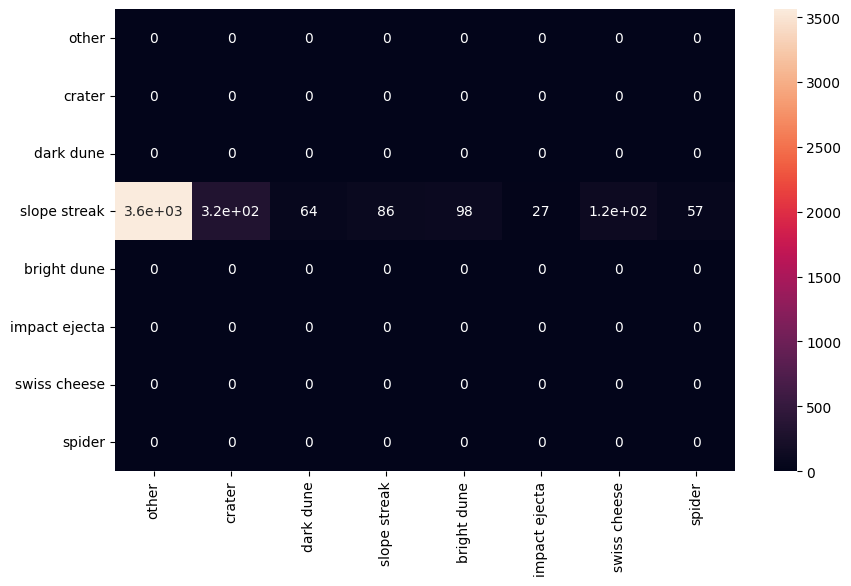

In [83]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

best_model = grid.best_estimator_
y_pred_class = best_model.predict(X_test)
print(X_test.shape)
print(y_test.shape)
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class, target_names=class_names))
fig = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_pred_class, y_test), xticklabels=class_names, yticklabels=class_names, annot=True)
plt.show()